# GERMAN POWER PRICE ANALYSIS
<b>Background</b>

You are provided with a comprehensive dataset containing German electricity market data (*Price_de* as target variable) along with fundamental supply and demand factors across European markets. 
Your task is to analyze the relationship between these fundamentals and German power prices, with particular focus on understanding price dynamics during peak hours.

**Dataset Overview**

- Target Variable: Price_de - German electricity prices
- Timeframe: ~22,000 hourly observations
- Scope: European power market fundamentals with focus on German market
**Key Fundamental Categories Available:**

Supply Side Factors:
- Conventional Generation: Coal, Gas, Lignite, Nuclear availability and generation
- Renewable Generation: Solar, Wind, Hydro across multiple countries
- Cross-border Flows: Net Transfer Capacities (NTC) between countries

Demand Side Factors:
- Power Demand: Across Germany, Netherlands, France, UK, and other European markets
- Weather Variables: Temperature data affecting both demand and renewable output

Market Indicators:
- Commodity Prices: Coal (API2), Gas (TTF, PEG, VTP, THE, PVB), Carbon (EUA)
- Generation Costs: Cost variables for different countries and fuel types

In [265]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import pylab as py
import seaborn as sns


path = '../data/dataframe.csv'
df = pd.read_csv(path)

In [266]:
# Dimension Dataframe
df.shape

(21911, 96)

## PART 1: DATA EXPLORATION AND UNDERSTANDING
### (1) Load and examine the dataset structure
    - What time period does this data cover?
    - Are there any missing values or data quality issues?
    - What is the frequency of observations?

In [267]:
print(df.head())

              reference_date  Price_de  Coal_avail_de    Demand_de  \
0  2023-09-01 00:00:00+02:00     98.90         9497.0  43502.14002   
1  2023-09-01 01:00:00+02:00     95.97         9497.0  41682.35598   
2  2023-09-01 02:00:00+02:00     93.29         9497.0  41093.58105   
3  2023-09-01 03:00:00+02:00     93.07         9497.0  41176.69539   
4  2023-09-01 04:00:00+02:00     94.08         9497.0  42085.08745   

   Gas_avail_de  Lignite_avail_de  Ntc_dkno_de  Solar_de   Temp_de   Wind_de  \
0       12327.5           12522.0          NaN      3.50  14.27045  12940.25   
1       12327.5           12522.0          NaN      2.75  14.05581  12407.25   
2       12327.5           12522.0          NaN      2.25  13.89315  11835.00   
3       12218.5           12522.0          NaN      2.25  13.71470  11182.50   
4       12218.5           12299.0          NaN      2.50  13.72212  10503.25   

   ...  Temp_east  Wind_nordic  Wind_pol  Wind_uk  Cost_de  Cost_nl  cost_fr  \
0  ...   18.38345 

In [268]:
print(df.tail())

                  reference_date  Price_de  Coal_avail_de    Demand_de  \
21906  2026-03-01 20:00:00+01:00       NaN        11252.1  53308.11652   
21907  2026-03-01 21:00:00+01:00       NaN        11252.1  51306.43508   
21908  2026-03-01 22:00:00+01:00       NaN        11252.1  50644.81810   
21909  2026-03-01 23:00:00+01:00       NaN        11252.1  48319.57747   
21910  2026-03-02 00:00:00+01:00       NaN        11252.1  46578.02932   

       Gas_avail_de  Lignite_avail_de  Ntc_dkno_de  Solar_de  Temp_de  \
21906       15659.6           14696.0  4992.500000       0.0  0.92200   
21907       15659.6           14696.0  4984.000000       0.0  0.35060   
21908       15659.6           14696.0  4990.833333       0.0 -0.00234   
21909       15659.6           14696.0  5035.500000       0.0 -0.33894   
21910       15659.6           14696.0  4660.333333       0.0 -0.57826   

           Wind_de  ...  Temp_east  Wind_nordic  Wind_pol  Wind_uk    Cost_de  \
21906  26020.33710  ...   2.650930 

In [269]:
# Before everythings i want to remove timezone info 
df['reference_date'] = pd.to_datetime(df['reference_date'], utc=True).dt.tz_localize(None) 
df = df.sort_values(by='reference_date') 
print(df.head())

       reference_date  Price_de  Coal_avail_de    Demand_de  Gas_avail_de  \
0 2023-08-31 22:00:00     98.90         9497.0  43502.14002       12327.5   
1 2023-08-31 23:00:00     95.97         9497.0  41682.35598       12327.5   
2 2023-09-01 00:00:00     93.29         9497.0  41093.58105       12327.5   
3 2023-09-01 01:00:00     93.07         9497.0  41176.69539       12218.5   
4 2023-09-01 02:00:00     94.08         9497.0  42085.08745       12218.5   

   Lignite_avail_de  Ntc_dkno_de  Solar_de   Temp_de   Wind_de  ...  \
0           12522.0          NaN      3.50  14.27045  12940.25  ...   
1           12522.0          NaN      2.75  14.05581  12407.25  ...   
2           12522.0          NaN      2.25  13.89315  11835.00  ...   
3           12522.0          NaN      2.25  13.71470  11182.50  ...   
4           12299.0          NaN      2.50  13.72212  10503.25  ...   

   Temp_east  Wind_nordic  Wind_pol  Wind_uk  Cost_de  Cost_nl  cost_fr  \
0   18.38345      4827.00       NaN

In [270]:
# 1.1) Time period does the data(frame) cover?
start_date = df['reference_date'].min()
end_date = df['reference_date'].max()
print(f"Start date: {start_date}")
print(f"End date: {end_date}")

Start date: 2023-08-31 22:00:00
End date: 2026-03-01 23:00:00


In [271]:
# 1.2) Are there any missing values or data quality issues?
"""
Devo analizzare tutti i campi o solo un subset di campi?
"""

print("German price descriptive stats:")
print(df["Price_de"].describe(),"\n")

German price descriptive stats:
count    18070.000000
mean        83.588906
std         58.810120
min       -250.320000
25%         59.070000
50%         86.355000
75%        109.307500
max       2325.830000
Name: Price_de, dtype: float64 



In [272]:
# 1.3) What is the frequency of observations?
time_diff = df['reference_date'].diff()
print(time_diff.describe(),"\n")
"""The max reveals that one timestamp is missing!"""

count                        21910
mean     0 days 01:00:00.492925604
std      0 days 00:00:42.123273684
min                0 days 01:00:00
25%                0 days 01:00:00
50%                0 days 01:00:00
75%                0 days 01:00:00
max                0 days 02:00:00
Name: reference_date, dtype: object 



'The max reveals that one timestamp is missing!'

In [273]:
# Count how many time differences equal exactly 2 hours
num_two_hour_gaps = (time_diff == pd.Timedelta('2h')).sum()

print("Number of 2-hour gaps:", num_two_hour_gaps)

Number of 2-hour gaps: 3


In [274]:
# Check for missing hourly timestamps
full_range = pd.date_range(df['reference_date'].min(),
                           df['reference_date'].max(),
                           freq='h')

missing = full_range.difference(df['reference_date'])

print("Missing timestamps:")
print(missing)
"""2-hour gaps correspond to autumn timezone transitions, when clocks are moved forward by one hour skipping one timestamp."""

Missing timestamps:
DatetimeIndex(['2023-10-29 01:00:00', '2024-10-27 01:00:00',
               '2025-10-26 01:00:00'],
              dtype='datetime64[ns]', freq=None)


'2-hour gaps correspond to autumn timezone transitions, when clocks are moved forward by one hour skipping one timestamp.'

In [275]:
# How to deal with that? i choose to interpolate the value in the missing to preserve overall trend and continuity
# Reindex the dataframe to include all timestamps
df = df.set_index('reference_date').reindex(full_range)
# Interpolate missing values (linear interpolation)
df = df.interpolate(method='linear')
# Reset index if needed
df = df.reset_index().rename(columns={'index': 'reference_date'})

In [276]:
time_diff = df['reference_date'].diff()
print(time_diff.describe(),"\n")
"""We add some additional dates, make sense"""

count              21913
mean     0 days 01:00:00
std      0 days 00:00:00
min      0 days 01:00:00
25%      0 days 01:00:00
50%      0 days 01:00:00
75%      0 days 01:00:00
max      0 days 01:00:00
Name: reference_date, dtype: object 



'We add some additional dates, make sense'

### (2) Initial price analysis
- Plot the German electricity price (Price_de) over time
- What patterns do you observe in the price series?
- Identify and describe any seasonal patterns, trends, or anomalies

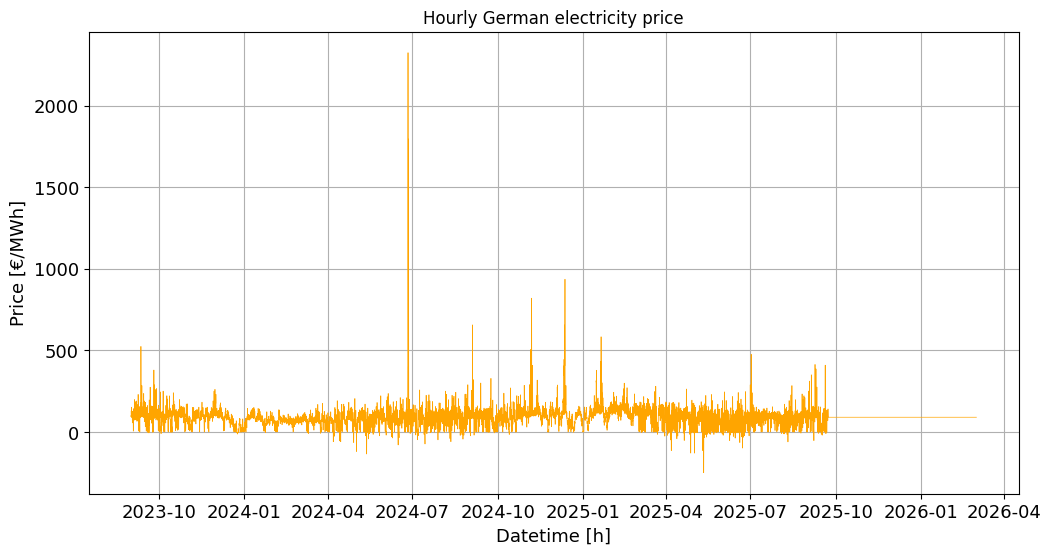

In [277]:
# 2.1) Plot the German electricity price (Price_de) over time
df.set_index('reference_date', inplace=True) # set reference_date as index to plot

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["Price_de"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13)
ax.set_ylabel("Price [€/MWh]", fontsize=13)
plt.title("Hourly German electricity price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()


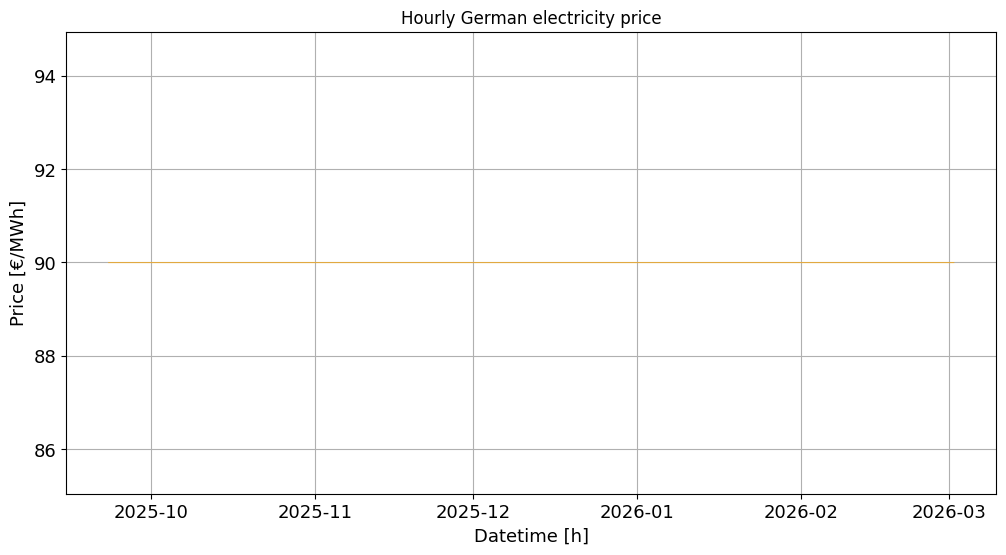

In [278]:
df_filtered = df.loc['2025-09-22 23:00:00':]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered["Price_de"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13)
ax.set_ylabel("Price [€/MWh]", fontsize=13)
plt.title("Hourly German electricity price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

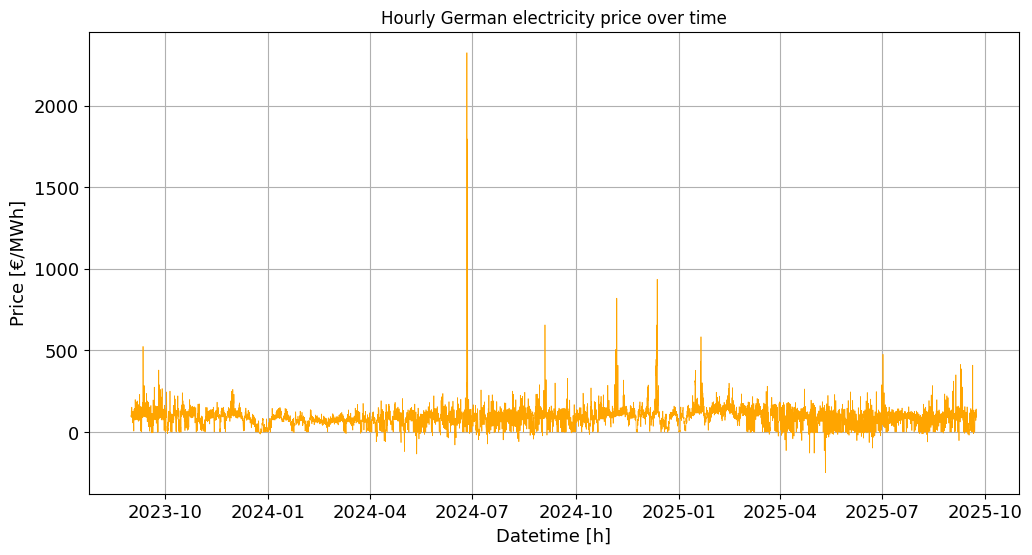

In [279]:
# filtro le date
df_filtered = df.loc[:'2025-09-22 23:00:00']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_filtered["Price_de"], linewidth=0.5, c='orange', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13)
ax.set_ylabel("Price [€/MWh]", fontsize=13)
plt.title("Hourly German electricity price over time")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

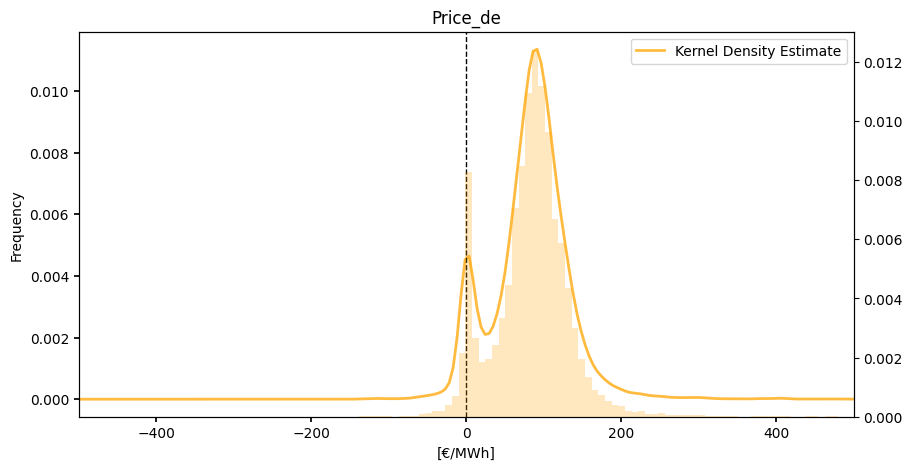

'We can observe the sum ok two normal likelihood sistribution'

In [280]:
# 2.2) What patterns do you observe in the price series?
"""
Kernel Density Estimator provides a rational and visually pleasant representation of the data distribution
"""
# Parameters
n_bins = 300  
DPI = 100  

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot Kernel Density Estimate (KDE)
df_filtered.plot(y="Price_de", ax=ax, kind="kde", color='orange', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate")

# Plot Histogram
df_filtered.plot(y="Price_de", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='orange', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

# Set title and labels
ax.set_title("Price_de")
ax.set_xlabel("[€/MWh]")

# Set x-limits for better visibility
ax.set_xlim(-500, 500)

# Customize ticks
ax.tick_params(width=1.25)

# Add a vertical line at x=0
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)

# Display legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

"""We can observe the sum ok two normal likelihood sistribution"""

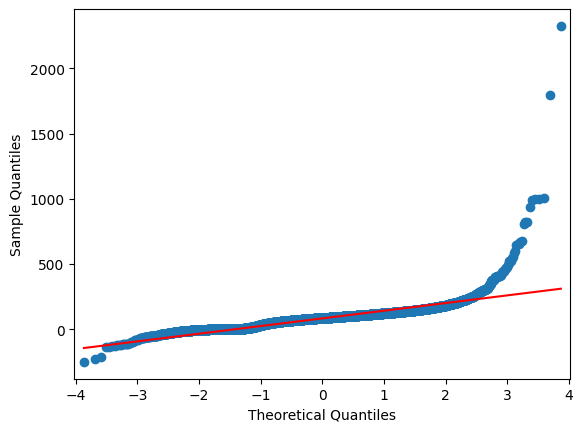

'From qq-plot we can deduce that the distribution has big tail, expecially the positive one'

In [281]:
# QQ-plot
sm.qqplot(df_filtered["Price_de"], line='s')

py.show()
"""From qq-plot we can deduce that the distribution has big tail, expecially the positive one"""

In [282]:
from scipy.stats import kstest, norm
ks_statistic, p_value = kstest(df_filtered["Price_de"], cdf="norm")
print(f"KS statistic: {ks_statistic:.3e}, p-value: {p_value:.3e}")

"""
--KS test for normality--
H0: Data is normally distributed

pvalue=0.0-> reject H0
"""

KS statistic: 9.062e-01, p-value: 0.000e+00


'\n--KS test for normality--\nH0: Data is normally distributed\n\npvalue=0.0-> reject H0\n'

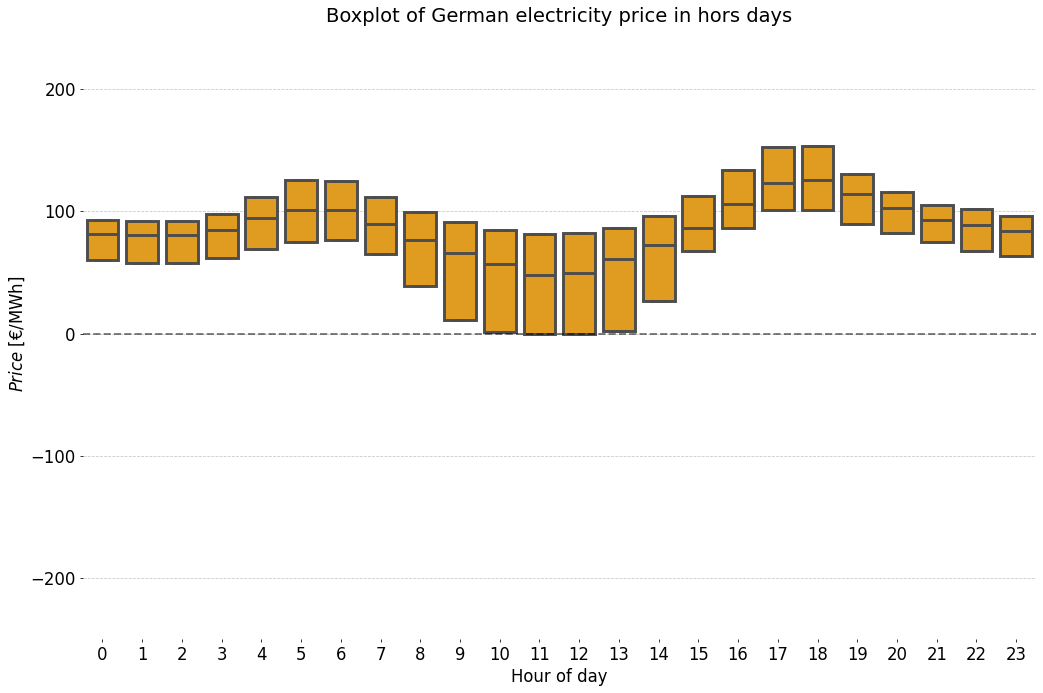

'Prices are lowest at night and around mid-day, likely due to solar generation, and peak in the morning and evening when electricity demand is highest.'

In [284]:
# 2.3) Identify and describe any seasonal patterns, trends, or anomalies

DPI = 70

df_filtered.loc[:, 'hour'] = df_filtered.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=df_filtered, x="hour", y="Price_de", fliersize=0, whis=0, color='orange', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$Price$ [€/MWh]", fontsize=17)
ax.set_title("Boxplot of German electricity price in hors days", fontsize=20)
# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-250, 250])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()
"""Prices are lowest at night and around mid-day, likely due to solar generation, and peak in the morning and evening when electricity demand is highest."""

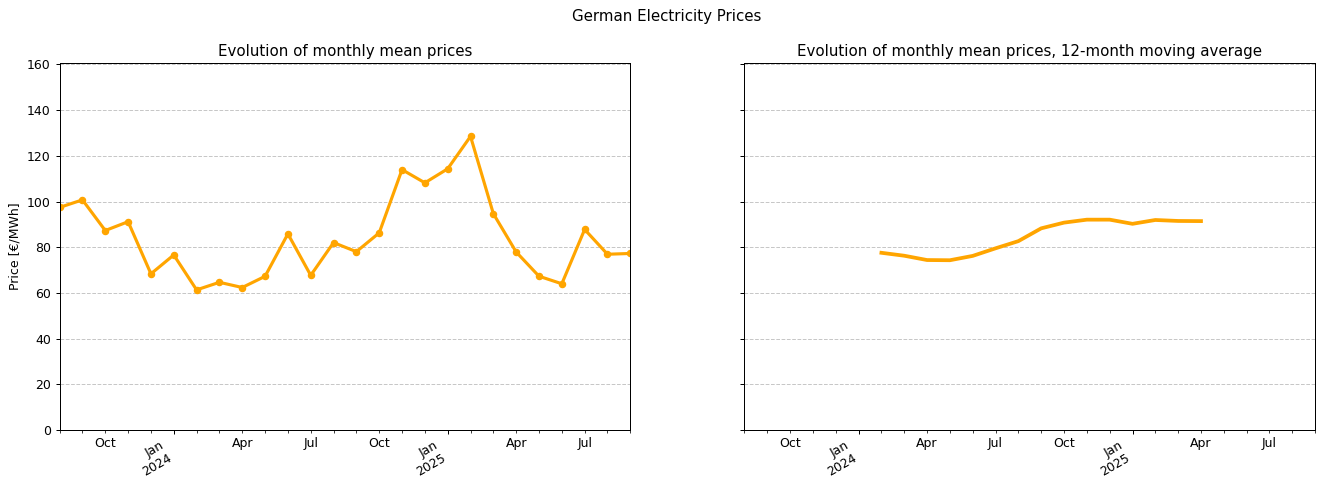

In [285]:
# Wanna try to aggregate over months

qh_price_copy = df_filtered.copy()  # or your original price DataFrame
qh_price_copy['year'] = qh_price_copy.index.year
qh_price_copy['month'] = qh_price_copy.index.month


agg_month_price = (
    qh_price_copy
    .groupby(by=["year", "month"])["Price_de"]
    .mean() 
)


agg_month_price.index = pd.date_range(
    start=pd.Timestamp(f"{agg_month_price.index[0][0]}-{agg_month_price.index[0][1]}"),
    end=pd.Timestamp(f"{agg_month_price.index[-1][0]}-{agg_month_price.index[-1][1]}"),
    freq="1MS"  # month start frequency
)

rolling_window = 12  # 12month rolling mean


fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=90, sharex=True, sharey=True)

agg_month_price.plot(ax=ax[0],
                     ylabel="Price [€/MWh]",
                     c="orange",
                     linewidth=2.5,
                     title="Evolution of monthly mean prices")
agg_month_price.plot(ax=ax[0],
                     style=".",
                     color="orange",
                     markersize=10)

agg_month_price.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                                 ylabel="Price [€/MWh]",
                                                                 c="orange",
                                                                 linewidth=3,
                                                                 title=f"Evolution of monthly mean prices, {rolling_window}-month moving average")


plt.ylim(0, 1.25 * agg_month_price.max())


ax[0].grid(True, axis='y', linestyle='--', alpha=0.7)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.7)
fig.autofmt_xdate()
fig.suptitle('German Electricity Prices')
plt.show()

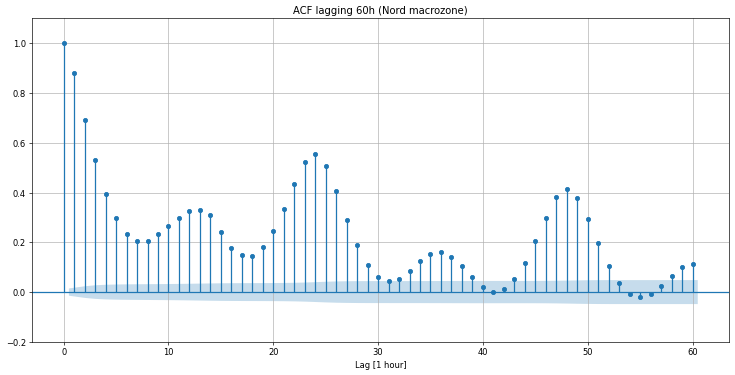

'The first ~3 lags (not considering the lag=0) have the most significant partial autocorrelation. then the lags corresponding to 24h and 48h (also 12h) show noticeable levels.'

In [293]:
# ACF: lets analyze autocorrelation in Price_de

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(df_filtered["Price_de"], alpha=.05, lags=12*5,
                         ax=ax, title="ACF lagging 60h")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [1 hour]')
plt.grid()
plt.show()
"""Remember that autocorrelation values outside this band are statistically significant at the 5% significance level!!!!"""
"""The first ~3 lags (not considering the lag=0) have the most significant partial autocorrelation. then the lags corresponding to 24h and 48h (also 12h) show noticeable levels."""

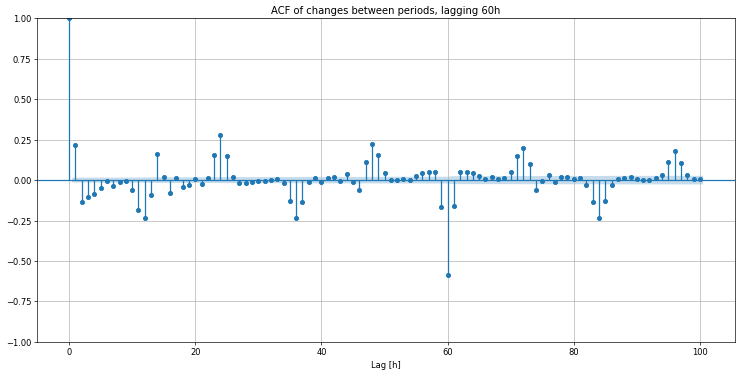

In [295]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(df_filtered["Price_de"].diff().diff(12*5).dropna(), alpha=.05, lags=100,
                         ax=ax, title="ACF of changes between periods, lagging 60h")
# plt.ylim(-0.3, 1.1)
plt.xlabel('Lag [h]')
plt.grid()
plt.show()

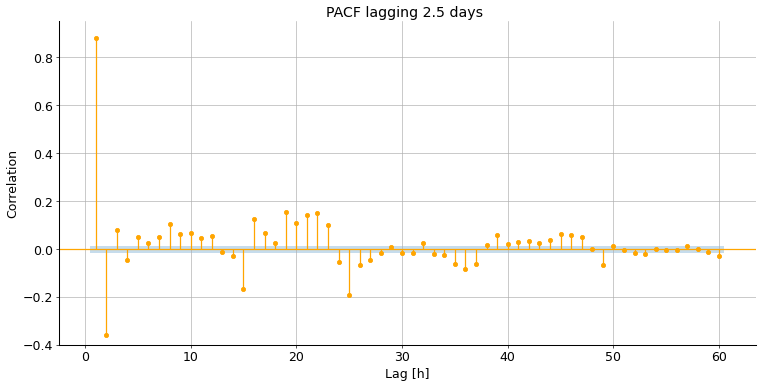

In [299]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_pacf(df_filtered["Price_de"], alpha=.05, lags=12*5, 
                         zero=False,
                         ax=ax,
                         color="orange", vlines_kwargs={"colors": "orange"})
plt.ylim(-0.4, 0.95)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [h]", fontsize=15)
ax.set_title("PACF lagging 2.5 days ", fontsize=17)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("orange")
plt.grid()
plt.show()

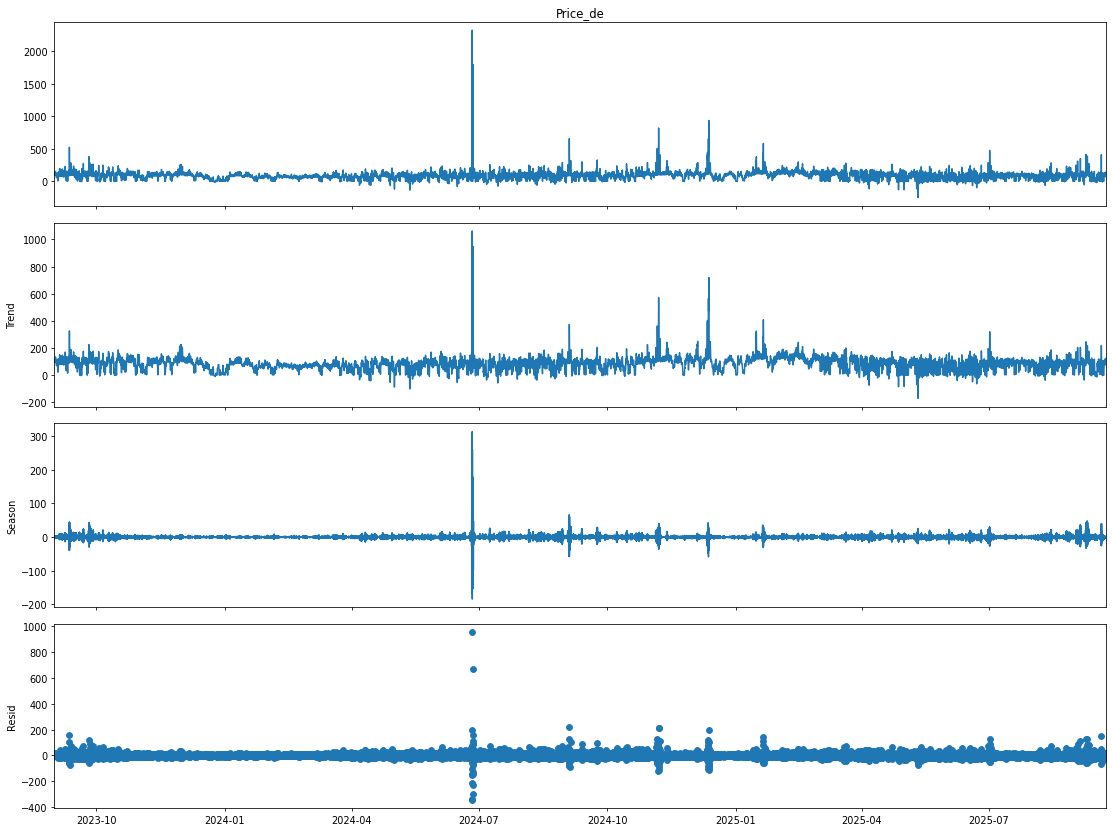

In [301]:
#STL Decomposition

from statsmodels.tsa.seasonal import STL

# Attempt STL decomposition:
try_STL = True

if try_STL:
    decomp = STL(endog=df_filtered["Price_de"], period = 4).fit()   # , period=4, trend=int(4*24*7*4.35), seasonal=int(4*24*7*4.35), robust=True

    plt.rc('figure', figsize=(16, 12), dpi=DPI)
    decomp.plot()
    plt.show()
    plt.rcdefaults()

Commentare ...